# ViTs From Scratch
### Chapter 4 Module 3

Now we are going to go for gold and build it all from scratch. No helpers other than torch and torchvision, let's dive into building a transformer for computer vision ourselves!

## Importing Libraries
First things first, let's set up some config and import our libraries for our model. We will be referencing these variables throughout the model architecture.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Basic configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 64
EPOCHS = 5
LR = 3e-4

IMAGE_SIZE = 28
PATCH_SIZE = 7  # 28 / 7 = 4x4 patches
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

EMBED_DIM = 64
NUM_CLASSES = 10
NUM_HEADS = 4
NUM_LAYERS = 2
MLP_DIM = 128

## Loading the MNIST Dataset
This step downloads and prepares the MNIST dataset using torchvision.datasets. The images are transformed to tensors for model compatibility.

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root=".", train=True, download=True, transform=transform)
test_data = datasets.MNIST(root=".", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.62MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 3.18MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 6.83MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.40MB/s]


## Defining the Patch Embedding Layer
The Vision Transformer begins by splitting the image into fixed-size patches and embedding them into a higher-dimensional space. This class uses a convolutional layer to simulate that process.

In [3]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=1, patch_size=PATCH_SIZE, emb_dim=EMBED_DIM):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, emb_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # x: [B, 1, 28, 28] → [B, emb_dim, 4, 4] → flatten to [B, 16, emb_dim]
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

## Positional Encoding
Since transformers are permutation-invariant, this module adds learnable positional encodings to each patch to maintain spatial information.

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, num_patches, emb_dim):
        super().__init__()
        self.pos_embed = nn.Parameter(torch.randn(1, num_patches + 1, emb_dim))  # +1 for [CLS] token

    def forward(self, x):
        return x + self.pos_embed

## Transformer Encoder Block
This defines a single encoder block consisting of multi-head self-attention and a feed-forward neural network, wrapped with layer normalization and residual connections.

In [5]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self, emb_dim, num_heads, mlp_dim):
        super().__init__()
        self.ln1 = nn.LayerNorm(emb_dim)
        self.attn = nn.MultiheadAttention(emb_dim, num_heads, batch_first=True)
        self.ln2 = nn.LayerNorm(emb_dim)
        self.mlp = nn.Sequential(
            nn.Linear(emb_dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, emb_dim)
        )

    def forward(self, x):
        # Self-attention with skip connection
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x))[0]
        # MLP with skip connection
        x = x + self.mlp(self.ln2(x))
        return x


## Full Vision Transformer (ViT) Model
This is the core ViT architecture combining patch embedding, positional encoding, a stack of transformer blocks, and a final classification head.

In [7]:
class ViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = PatchEmbedding()
        self.cls_token = nn.Parameter(torch.randn(1, 1, EMBED_DIM))
        self.pos_embed = PositionalEncoding(NUM_PATCHES, EMBED_DIM)
        
        self.encoder = nn.Sequential(*[
            TransformerEncoderBlock(EMBED_DIM, NUM_HEADS, MLP_DIM)
            for _ in range(NUM_LAYERS)
        ])

        self.head = nn.Sequential(
            nn.LayerNorm(EMBED_DIM),
            nn.Linear(EMBED_DIM, NUM_CLASSES)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.patch_embed(x)  # [B, 16, EMBED_DIM]
        
        cls_tokens = self.cls_token.expand(B, -1, -1)  # [B, 1, EMBED_DIM]
        x = torch.cat((cls_tokens, x), dim=1)  # [B, 17, EMBED_DIM]
        
        x = self.pos_embed(x)
        x = self.encoder(x)
        
        cls_output = x[:, 0]  # Use the [CLS] token output
        return self.head(cls_output)

## Training Loop
This loop handles the optimization of the ViT model on the MNIST training data using cross-entropy loss and Adam optimizer.

In [8]:
model = ViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

for epoch in range(EPOCHS):
    model.train()
    total, correct = 0, 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        preds = model(imgs)
        loss = criterion(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        correct += (preds.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Acc: {train_acc:.4f}")

Epoch 1/5 - Train Acc: 0.7932
Epoch 2/5 - Train Acc: 0.9389
Epoch 3/5 - Train Acc: 0.9552
Epoch 4/5 - Train Acc: 0.9627
Epoch 5/5 - Train Acc: 0.9680


## Evaluation Loop
After training, this cell evaluates the model on the MNIST test set to calculate accuracy.

In [9]:
model.eval()
total, correct = 0, 0

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        preds = model(imgs)

        correct += (preds.argmax(dim=1) == labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9690


In [12]:
preds.argmax(dim=1)

tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

## Loading MNIST into FiftyOne
This step loads the MNIST test set into FiftyOne for visualization and further analysis.

Split 'test' already downloaded
Loading 'mnist' split 'test'
 100% |█████████████| 10000/10000 [1.7s elapsed, 0s remaining, 5.9K samples/s]         
Dataset 'mnist-test' created



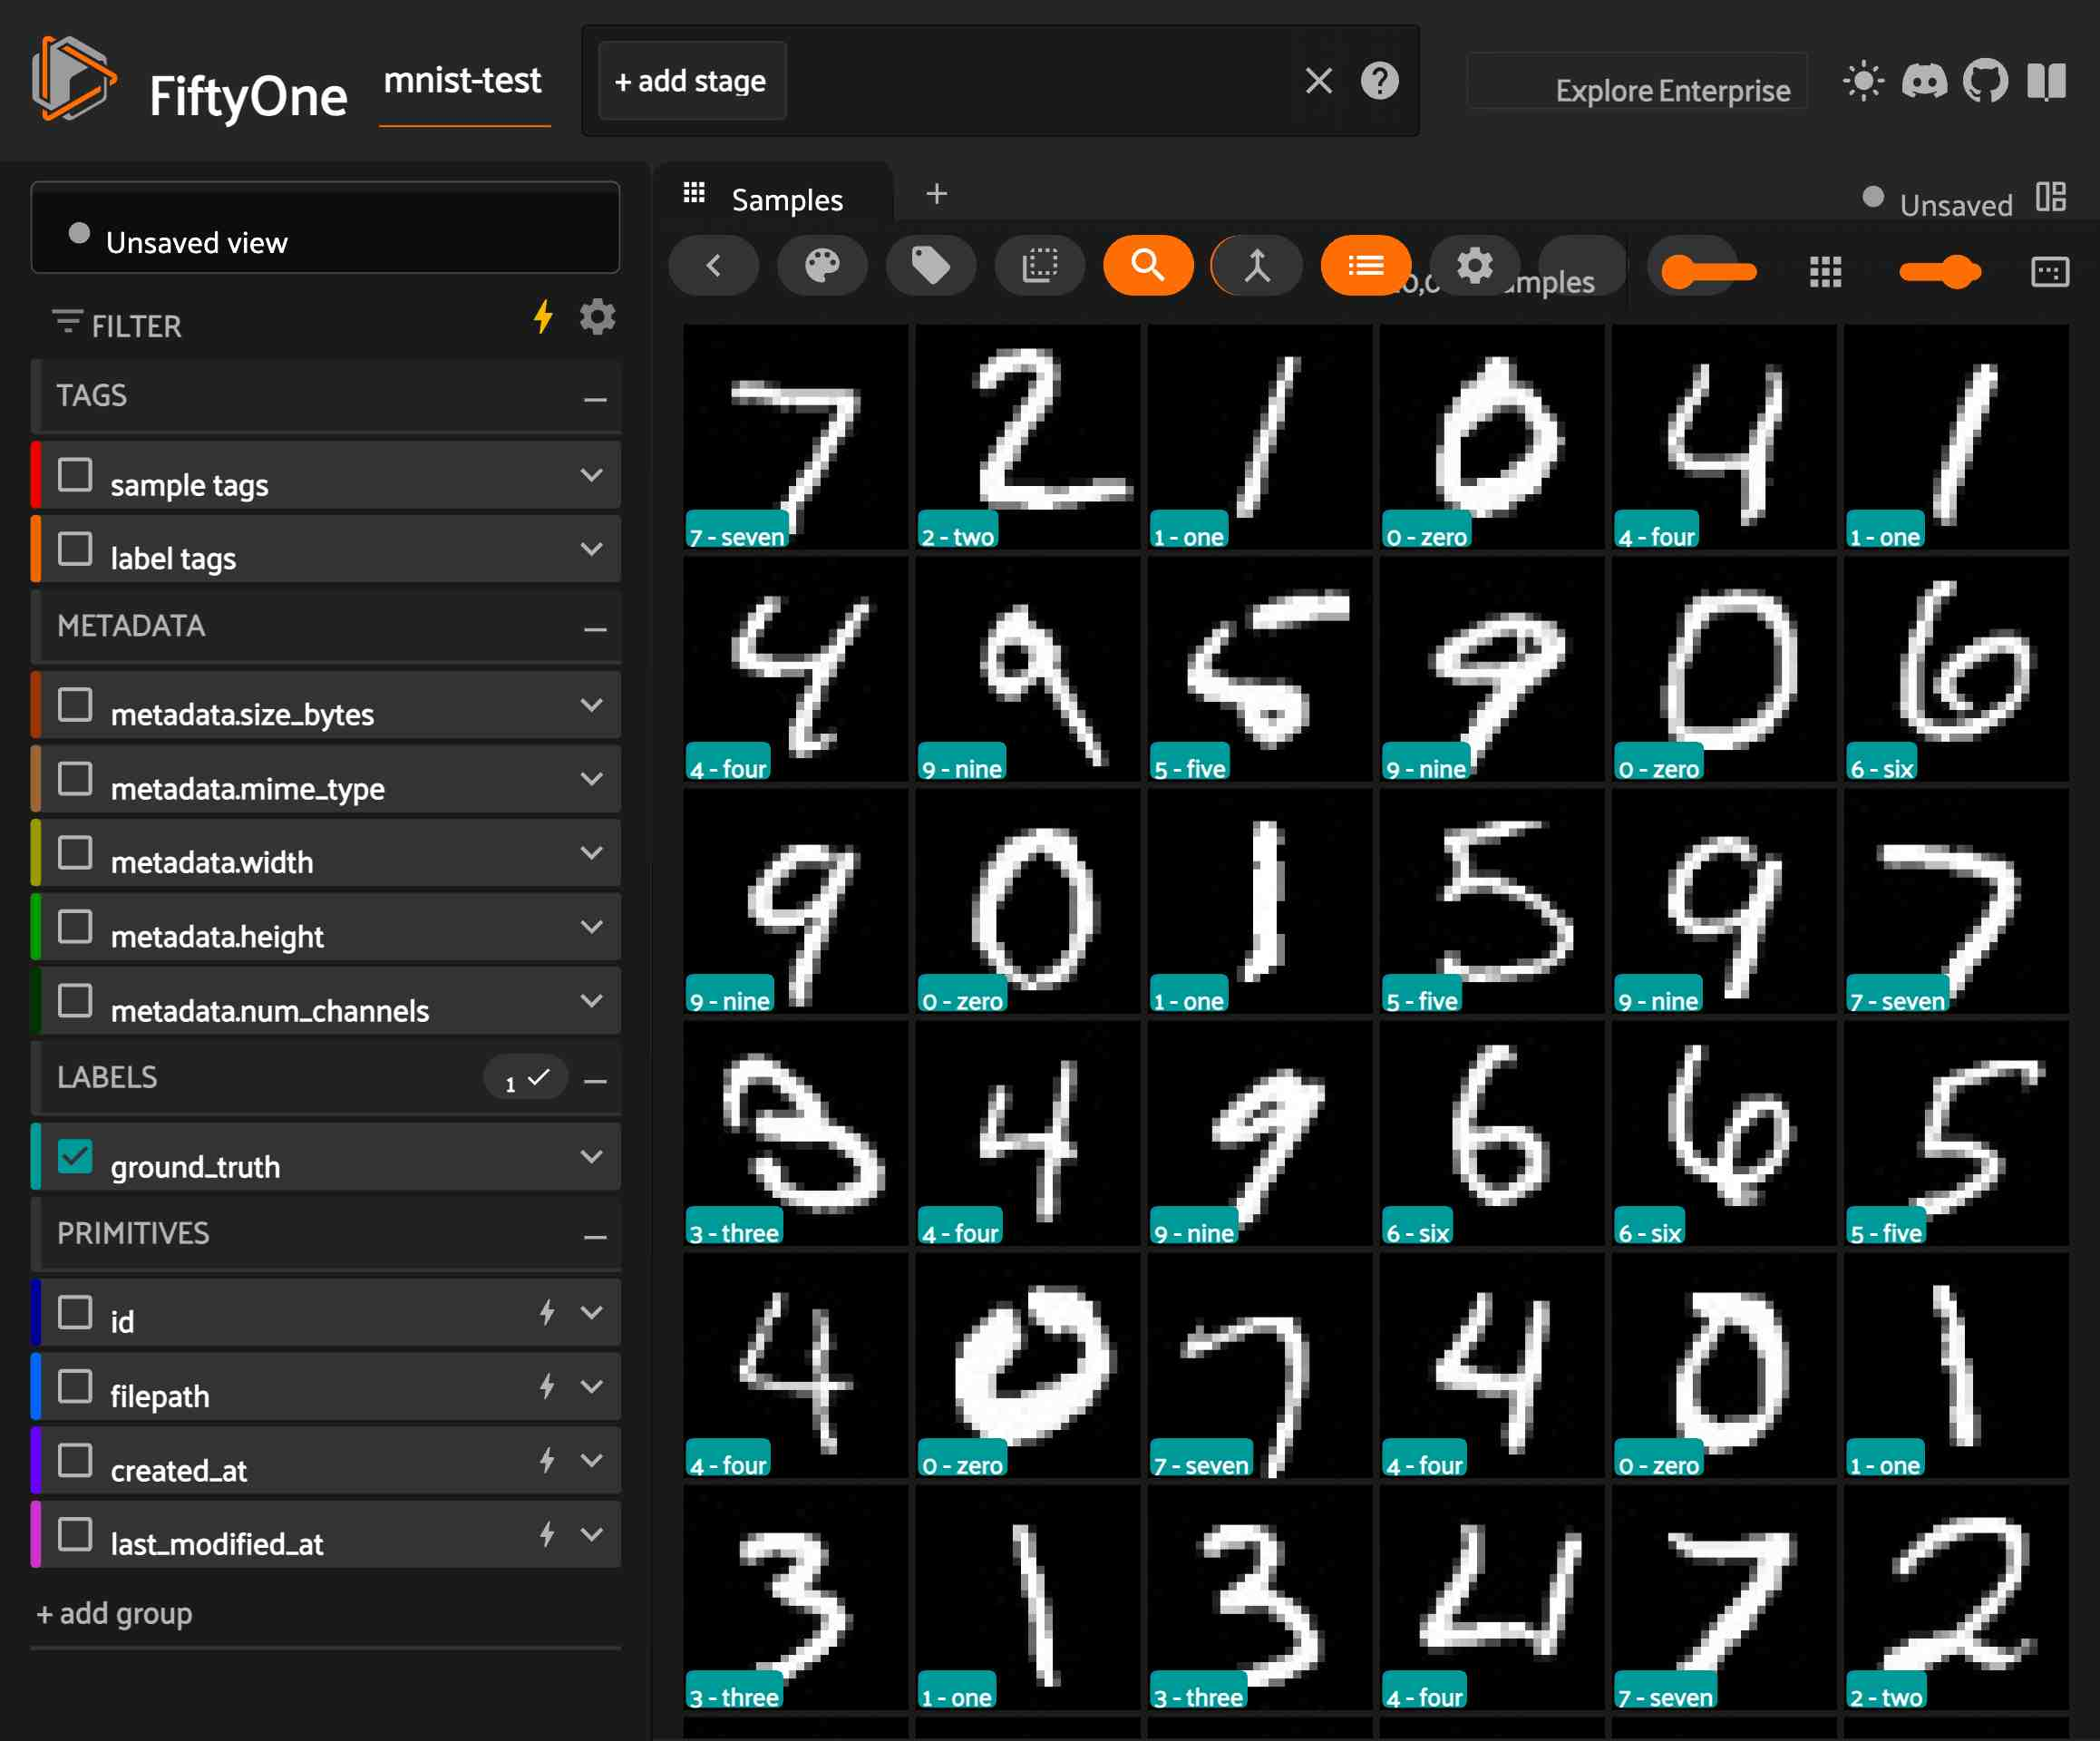

In [ ]:
import fiftyone as fo
import fiftyone.zoo as foz

dataset = foz.load_zoo_dataset("mnist", split="test")

session = fo.launch_app(dataset)

## Formatting Labels
Here, the predicted labels are mapped to descriptive strings (e.g., “3 – three”) for better clarity in FiftyOne.


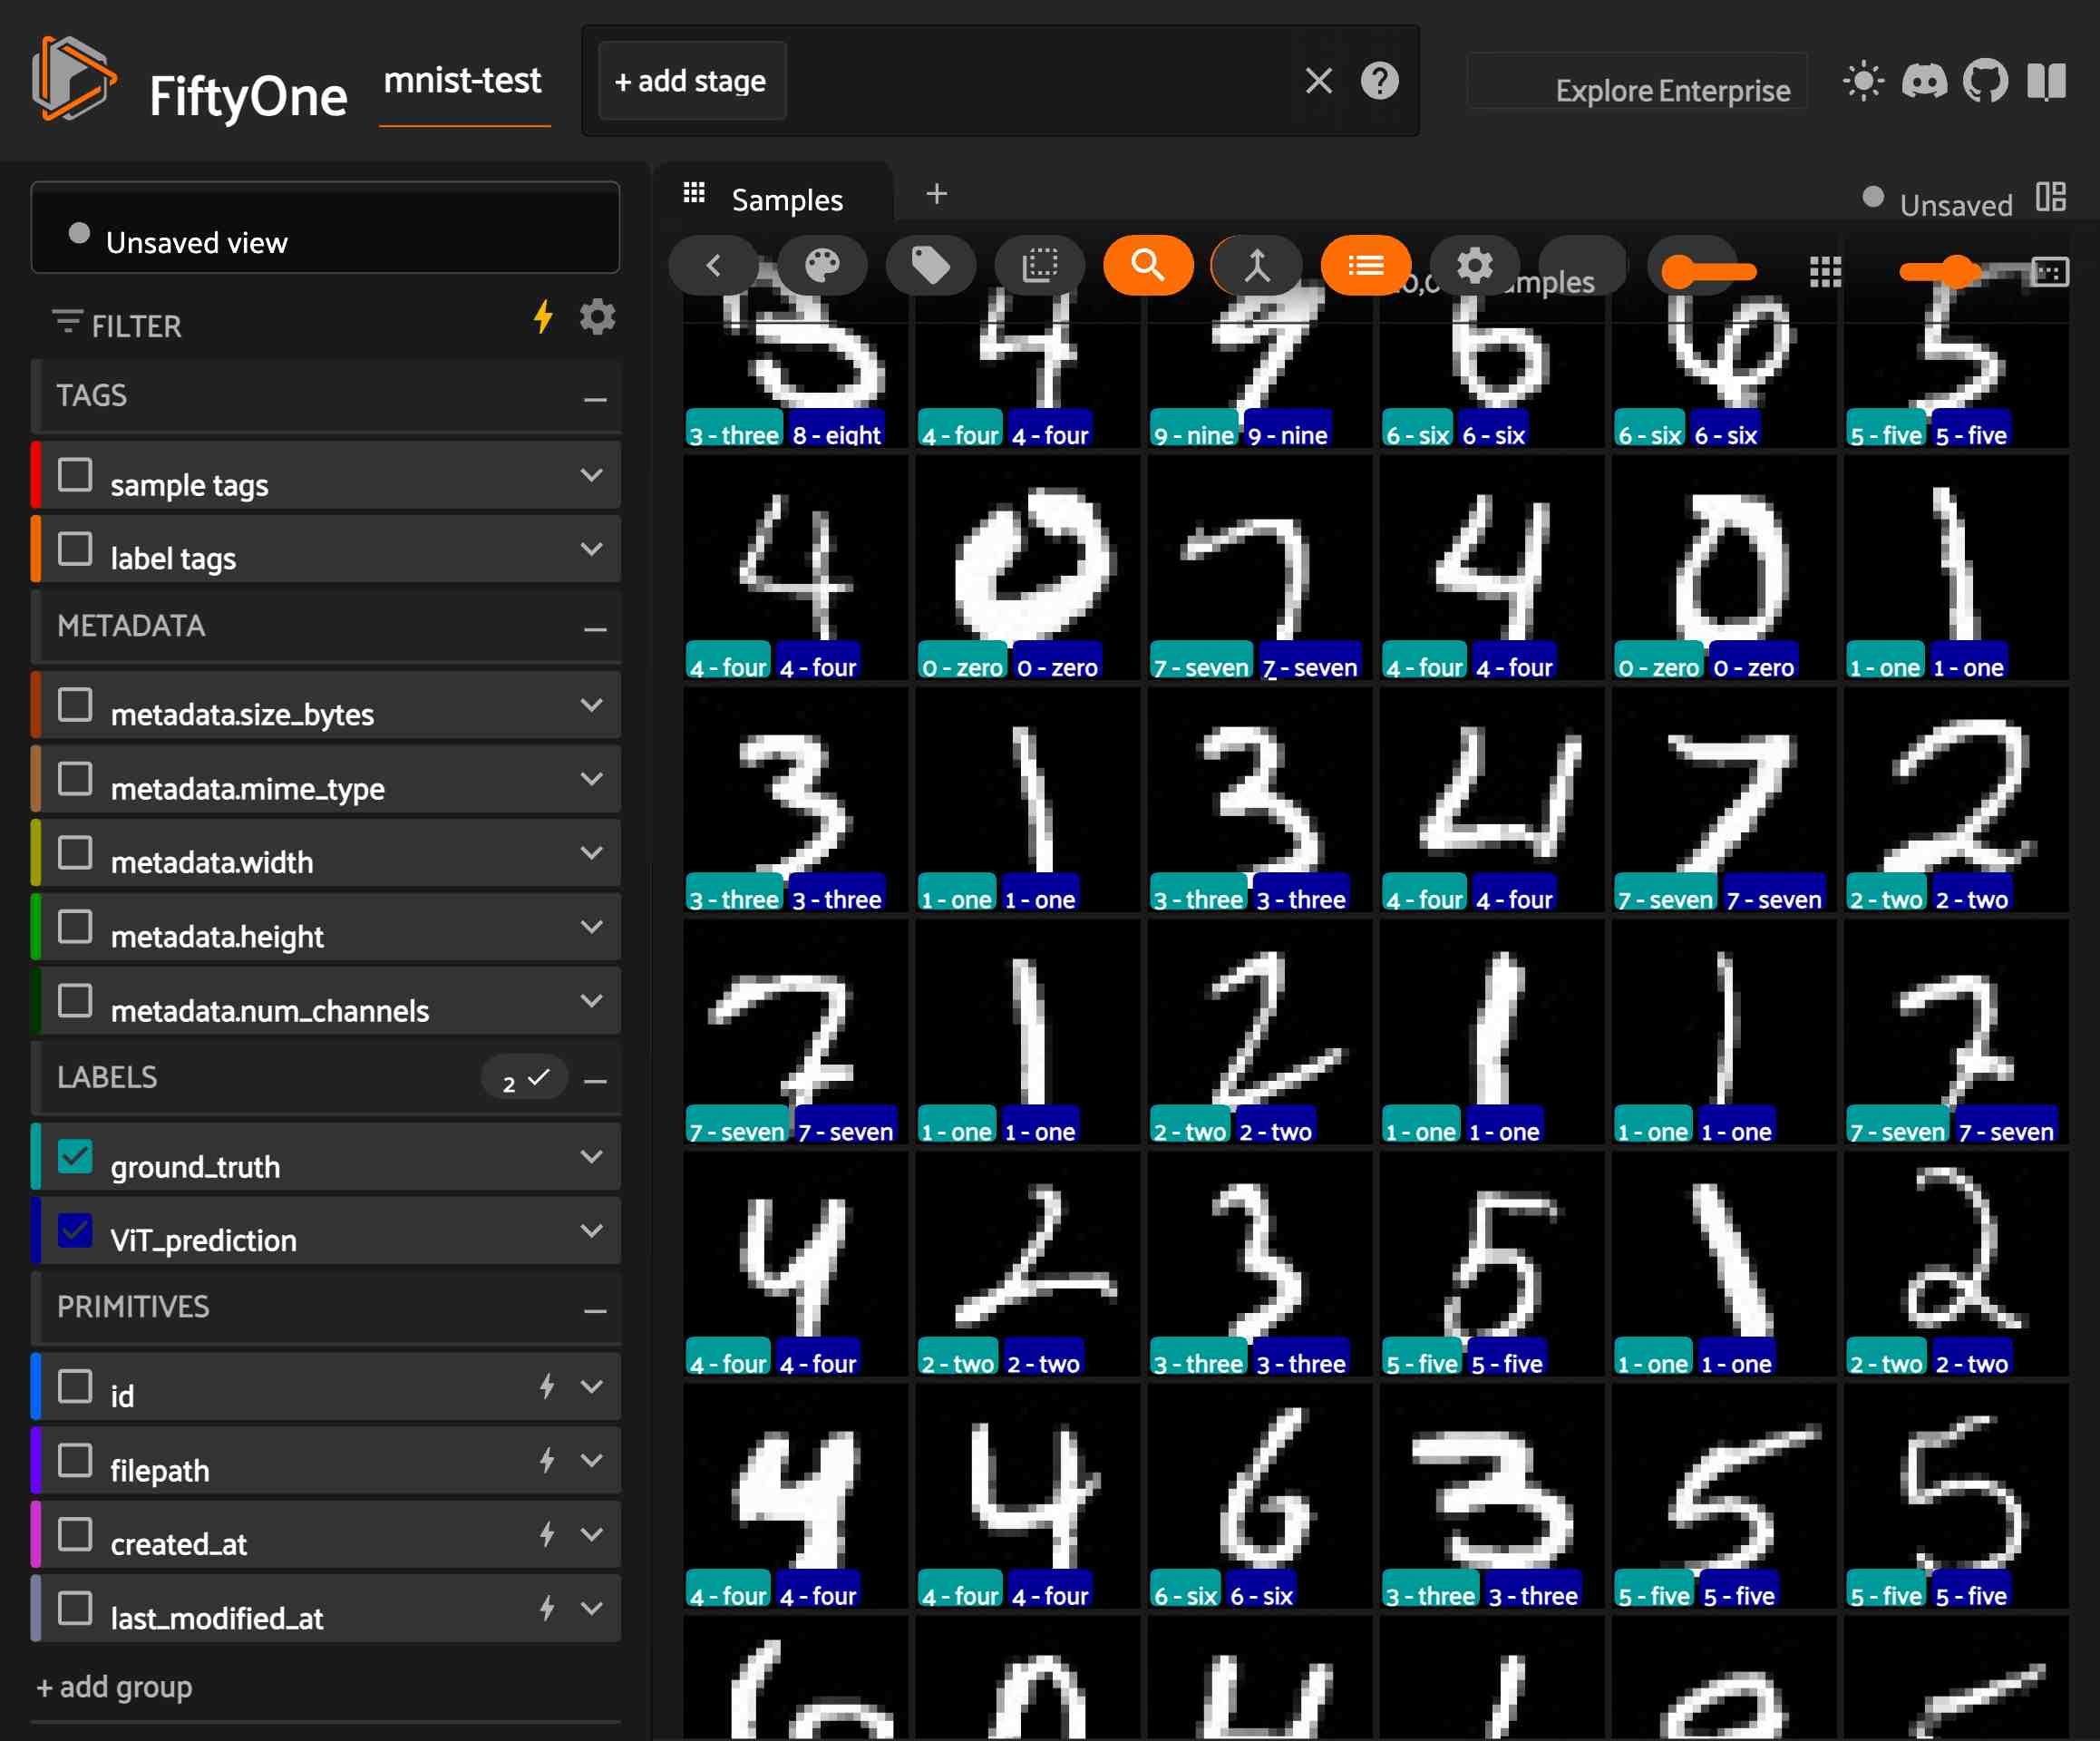

In [ ]:
from PIL import Image
label_map = {0: "0 - zero", 1: "1 - one", 2: "2 - two", 3: "3 - three", 4: "4 - four", 
              5: "5 - five", 6: "6 - six", 7: "7 - seven", 8: "8 - eight", 9: "9 - nine"}

for sample in dataset:
    sample_tensor = transform(Image.open(sample.filepath).convert("L")).unsqueeze(0)
    sample_tensor = sample_tensor.to(device)
    pred = model(sample_tensor).argmax(dim=1).item()
    sample["ViT_prediction"] = fo.Classification(label=label_map[pred])
    sample.save()

session.show()

## Evaluating Predictions
This evaluates the model's predictions using FiftyOne’s built-in classification metrics and prints a performance report.

In [26]:
results = dataset.evaluate_classifications(ground_truth="ground_truth", pred_field="ViT_prediction", eval_key="eval")
results.print_report()

              precision    recall  f1-score   support

    0 - zero       0.97      0.99      0.98       980
     1 - one       0.98      0.99      0.99      1135
     2 - two       0.97      0.96      0.96      1032
   3 - three       0.99      0.95      0.97      1010
    4 - four       0.96      0.97      0.97       982
    5 - five       0.96      0.97      0.96       892
     6 - six       0.98      0.96      0.97       958
   7 - seven       0.98      0.95      0.96      1028
   8 - eight       0.93      0.98      0.95       974
    9 - nine       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## Filtering Misclassifications
This creates a filtered view of only the incorrectly predicted samples for inspection.

In [ ]:
from fiftyone import ViewField as F
view = dataset.match(F("eval")==False)
print(view)

Dataset:     mnist-test
Media type:  image
Num samples: 312
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    ground_truth:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    ViT_prediction:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    eval:             fiftyone.core.fields.BooleanField
View stages:
    1. Match(filter={'$expr': {'$eq': [...]}})


In [ ]:
session.view = view

Model Eval Panel!